# NYC Taxi fare problem - Assignment 2
***
> ##### __Author__: _Vanshaj Lokwani_
> ##### __SBU ID__: _112025869_

In [1]:
# Importing the tools required
import pandas as pd
import numpy as np
import sklearn as skl
from matplotlib import pyplot as plt
import seaborn as sns

The dataset contains 55M rows and trying to load all of them at once causes the system to hang and intermittently crash. For the initial cleaning and testing phase, using a subset of the data. Once we have an idea of the actual cleaning effort required, we can iteratively perform that on the whole dataset for further processing. 

__To begin with, I am using first 10M rows as our subset. There is no reason behind this and the number was selected by intuition. Choosing 10M rows gives us enough liberty with the data to identify patterns and the data is small enough to not overload the RAM during pre-processing__

In [2]:
# Getting the dataset
NUM_ROWS = 10**7 # 10M ROWS
train_df = pd.read_csv('../dataset/train.csv', nrows=NUM_ROWS)

Displaying the first 5 rows from the dataframe to get a rough idea of the DF looks like and if it's loaded correctly. 

In [3]:
display(train_df.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# Few steps to make our life easier in the long run.
# set the new index as the 'key' coumn. The dataset specifies that the key is unique overall
# the it does not make sense to maintain two different indexes. 
train_df.set_index('key', inplace=True, drop=True) 

#getting the columns in a list. Might be helpful later on. 
columns = list(train_df.columns)
display(columns)

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

## Question 1: 
##### ** Take a look at the training data. There may be anomalies in the data that you may need to factor in before you start on the other tasks. Clean the data first to handle these issues. Explain what you did to clean the data (in bulleted form). (10 pt) **


##### Let's print a summary of the data using the .describe() api provided in pandas. This may help us detect any anomalies that might exist in the system.

But before we get into that, we need to supress scientific notation in pandas. The easiest way to do this is to call 'set_option'. We'll set the precision for the number to be accurate upto 3 decimal places. More information on how to do that can be found at the stackoverflow link: https://stackoverflow.com/questions/21137150/format-suppress-scientific-notation-from-python-pandas-aggregation-results

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(train_df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000000.000,10000000.000,10000000.000,9999931.000,9999931.000,10000000.000
mean,11.339,-72.508,39.919,-72.509,39.919,1.685
std,9.800,12.994,9.323,12.875,9.237,1.323
min,-107.750,-3439.245,-3492.264,-3426.601,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3457.626,3344.459,3457.622,3351.403,208.000


#### We can already see that there are clearly some issues with the data. Let's pick the columns one by one.

__ColumnName__: *pickup_longitude, pickup_latitude, dropoff_longitude & dropoff_latitude* Possible Issues:

* dropoff_longitude and dropoff_latitude count is lesser compared to other columns. This signifies the presence of missing values or NaN values in the two columns. We would have to take care of these depending how many values are missing.

In [6]:
missing_long_indexes = train_df[train_df.dropoff_longitude.isnull().values].dropoff_longitude.index
missing_lat_indexes = train_df[train_df.dropoff_latitude.isnull().values].dropoff_latitude.index
missing_values_list = set(missing_long_indexes).union(set(missing_lat_indexes))
print("Number of rows with missing indexes: {}".format(len(missing_values_list)))

Number of rows with missing indexes: 69


the number seems small enough that these rows can be dropped without worrying about loosing important data. 69 in 10M is not a very significant number.  

In [7]:
train_df.drop(missing_values_list, inplace=True)

In [8]:
# describe api should return equal counts for all columns with no na values
display(train_df.describe())
display("Any null values left in the two columns: %s" % train_df[['dropoff_longitude', 'dropoff_latitude']].isnull().values.any())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999931.000,9999931.000,9999931.000,9999931.000,9999931.000,9999931.000
mean,11.338,-72.508,39.919,-72.509,39.919,1.685
std,9.800,12.994,9.323,12.875,9.237,1.323
min,-107.750,-3439.245,-3492.264,-3426.601,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3457.626,3344.459,3457.622,3351.403,208.000


'Any null values left in the two columns: False'

* The range of latitude values is -90 to 90 and the range of longitude values is -180 to 180. From the data summary, it's clear that the data does not follow the range. Calculating the number of points which are outside the range: 

In [9]:
# Out of Range = or_
or_pickup_longitude = set(train_df[(train_df.pickup_longitude < -180.0) | (train_df.pickup_longitude > 180.0)].index)
or_pickup_latitude = set(train_df[(train_df.pickup_latitude < -90.0) | (train_df.pickup_latitude > 90.0)].index)
or_dropoff_longitude = set(train_df[(train_df.dropoff_longitude < -180.0) | (train_df.dropoff_longitude > 180.0)].index)
or_dropoff_latitude = set(train_df[(train_df.dropoff_latitude < -90.0) | (train_df.dropoff_latitude > 90.0)].index)
or_indexes = or_pickup_longitude.union(or_pickup_latitude).union(or_dropoff_latitude).union(or_dropoff_longitude)
display("Number of rows with outside range values: %s" % len(or_indexes))

'Number of rows with outside range values: 476'

In [10]:
train_df.loc[list(or_indexes)].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,476.000,476.000,476.000,476.000,476.000,476.000
mean,10.737,-316.692,116.937,-258.439,63.743,1.901
std,8.741,1090.612,1017.041,1075.646,1004.023,2.719
min,2.500,-3439.245,-3492.264,-3426.601,-3488.080,1.000
25%,5.700,-736.367,40.721,-736.237,40.704,1.000
50%,8.100,-73.993,40.757,-73.990,40.756,1.000
75%,11.700,-73.960,288.889,-73.953,40.811,2.000
max,57.330,3457.626,3344.459,3457.622,3351.403,51.000


* 476 in ~10M is a very small percentage of datapoints. We can look into the datapoints individually later and try to figure out if there is any way we can fix these outliers but for now dropping the points.

In [11]:
train_df.drop(or_indexes, inplace=True)

In [12]:
display(train_df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9999455.000,9999455.000,9999455.000,9999455.000,9999455.000,9999455.000
mean,11.339,-72.496,39.916,-72.500,39.918,1.685
std,9.800,10.465,6.123,10.449,6.117,1.323
min,-107.750,-168.604,-74.824,-173.342,-74.193,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,154.101,89.742,154.101,81.555,208.000


* One more thing to note here, is that the data is the fares charged by NYC taxis. If the data is only from NYC taxis, then some of the of longitude/latitude datapoints will become outliers as these points are way beyond the city ( some even outside the United States). A simple search returns that the __range of latitudes and longitudes for NYC__ lie from:

_North Latitude: 40.917577 South Latitude: 40.477399 East Longitude: -73.700272 West Longitude: -74.259090_. 

**Source: https://www.mapdevelopers.com/geocode_bounding_box.php**

In [13]:
# Fetching all points in this range to get a better idea of the sample dataset. 

nyc_coordinates = train_df[(train_df['pickup_longitude'].between(-74.259090, -73.700272)) &
                             (train_df['pickup_latitude'].between(40.477399, 40.917577)) &
                             (train_df['dropoff_longitude'].between(-74.259090, -73.700272)) &
                             (train_df['dropoff_latitude'].between(40.477399, 40.917577))]

display(nyc_coordinates.describe(), nyc_coordinates.head())
nyc_coor_index = nyc_coordinates.index

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9776221.000,9776221.000,9776221.000,9776221.000,9776221.000,9776221.000
mean,11.279,-73.976,40.751,-73.975,40.751,1.685
std,9.460,0.034,0.027,0.034,0.031,1.314
min,-107.750,-74.259,40.478,-74.259,40.478,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.700,40.917,-73.700,40.918,208.000


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


~200,000 datapoints where dropped with geofencing the dataset. Although, this number is still small in front of ~9.8M datapoints availabel for prediction, but 200,000 in itself is a huge number and these many data points cannot be considered as outliers. Let's explore the dataset a little bit more to actually try and figure out if there is any thing from the remaining dataset that we can use. 

In [14]:
train_df.drop(nyc_coor_index).describe(np.linspace(0,1,101))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,223234.000,223234.000,223234.000,223234.000,223234.000,223234.000
mean,13.966,-7.710,3.341,-7.925,3.429,1.681
std,19.383,24.747,17.644,25.003,17.726,1.694
min,-100.000,-168.604,-74.824,-173.342,-74.193,0.000
0%,-100.000,-168.604,-74.824,-173.342,-74.193,0.000
1%,2.500,-74.286,-73.984,-74.291,-73.982,1.000
2%,2.500,-74.003,-73.950,-74.005,-73.941,1.000
3%,3.000,-73.991,0.000,-73.991,0.000,1.000
4%,3.500,-73.983,0.000,-73.983,0.000,1.000
5%,3.700,-73.975,0.000,-73.976,0.000,1.000


Looks like most of the values are 0.000 which can be safely ignored ( assuming people are not travelling to the middle of the atlantic ocean). 

In [15]:
# Fetching all points in this range to get a better idea of the sample dataset. 

# train_df = train_df[(train_df['pickup_longitude'].between(-74.286090, -73.700272)) &
#                              (train_df['pickup_latitude'].between(40.477399, 41.366000)) &
#                              (train_df['dropoff_longitude'].between(-74.286090, -73.700272)) &
#                              (train_df['dropoff_latitude'].between(40.477399, 41.366000))]

train_df = nyc_coordinates
display(train_df.head());display(train_df.describe())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9776221.000,9776221.000,9776221.000,9776221.000,9776221.000,9776221.000
mean,11.279,-73.976,40.751,-73.975,40.751,1.685
std,9.460,0.034,0.027,0.034,0.031,1.314
min,-107.750,-74.259,40.478,-74.259,40.478,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.700,40.917,-73.700,40.918,208.000



__ColumnName__: *fare_amount*
Possible Issues: 
* fare_amount is negative which should not be possible. Assumption: there was an issue with data entry or fare calculation. looking into the dataset to fetch all the rows where fare_amount is negetive.

In [16]:
neg_fare = train_df[train_df.fare_amount < 0]
display(neg_fare.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,379.000,379.000,379.000,379.000,379.000,379.000
mean,-8.691,-73.965,40.748,-73.964,40.747,1.826
std,13.789,0.052,0.035,0.054,0.040,1.388
min,-107.750,-74.230,40.583,-74.230,40.588,0.000
25%,-6.100,-73.990,40.734,-73.989,40.732,1.000
50%,-3.500,-73.979,40.755,-73.977,40.753,1.000
75%,-2.500,-73.959,40.766,-73.954,40.766,2.000
max,-0.010,-73.727,40.877,-73.727,40.888,6.000


Looking at the number of data points that have negative fare value is just 420 in ~10M. We can safely drop these values from the dataset as well.

In [17]:
train_df.drop(neg_fare.index, inplace=True)
display(train_df.head())
display(train_df.describe())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9775842.000,9775842.000,9775842.000,9775842.000,9775842.000,9775842.000
mean,11.279,-73.976,40.751,-73.975,40.751,1.685
std,9.459,0.034,0.027,0.034,0.031,1.314
min,0.000,-74.259,40.478,-74.259,40.478,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.700,40.917,-73.700,40.918,208.000


__ColumnName__: *passenger_count* Possible Issues:
* The maximum value of passenger_count reaches 208, which does not seem like it would be possible for a taxi. the maximum number of people allowed in a NYC taxi is 5 + a child below the age of 7. Let's take the case of a child in a taxi as a special case that we will deal with at a later point in time. Lets look at data where passenger count > 5.

In [18]:
train_df[train_df.passenger_count > 5.0].groupby('passenger_count').count()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
passenger_count,,,,,,
6,207333,207333,207333,207333,207333,207333
7,2,2,2,2,2,2
9,3,3,3,3,3,3
129,1,1,1,1,1,1
208,3,3,3,3,3,3


<p>The number of datapoints above 6 passengers is few in number. These can be considered as outliers and dropped safely. There is no point trying to fix the passenger counts because the change caused by these number will not be significant</p>

In [19]:
train_df.drop(train_df[train_df.passenger_count > 6].index, inplace=True)
display(train_df.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


In [20]:
display(train_df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000
mean,11.279,-73.976,40.751,-73.975,40.751,1.685
std,9.459,0.034,0.027,0.034,0.031,1.308
min,0.000,-74.259,40.478,-74.259,40.478,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,952.000,-73.700,40.917,-73.700,40.918,6.000


***********
#### Q2. Compute the Pearson correlation between the following: (9 pt)
####    a. Euclidean distance of the ride and the taxi fare
####    b. time of day and distance traveled
####    c. time of day and the taxi fare


**Calculating Distance: **

One way to calculate the haversine distance would be to get the haversine library from pypi and passing the pickup and dropoff coordinates to it. Seems straightforward enough to implement but to avoid the hassle of installing a new python library, I'm using the function below: 

**Source: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points **

In [21]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [22]:
# Calling the haversine function and storing the distance in df as h_dist
train_df['h_dist'] = train_df[[
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude']].apply(lambda x: haversine(*x), axis=1)

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist
key,,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1,1.031
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1,8.450
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2,1.390
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1,2.799
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1,1.999


The idea behind time-of-day function is to divide each day into 3 or 4 slots of ~equal timeslots, say 'morning', 'noon', 'evening', 'night' and use them to compare the variations in fare during these slots. 
The dataset has pickup_datetime attribute in the format %YYYY-%MM-%DD %HH:%MM:%SS UTC. For our time-of-day variable, we don't need the day or the timezone, but just the hour in which the ride started. In the next step let's extract the hour from the column.

In [23]:
train_df['pickup_hour'] = pd.to_datetime(train_df['pickup_datetime'].str.split(expand=True)[1], format="%H:%M:%S").dt.hour

display(train_df.dtypes); display(train_df.head())

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
h_dist               float64
pickup_hour            int64
dtype: object

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,pickup_hour
key,,,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1,1.031,17
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1,8.450,16
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2,1.390,0
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1,2.799,4
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1,1.999,7


We are condsidering 4 values for time-of-day with the specified ranges:
* Morning: 5 to 12
* Noon: 12 to 5
* Evening: 5 to 10
* Night: 10 to 5

In [24]:
def convert_to_time_of_day(hour):
    if hour >= 22 or hour < 5:
        return "Night"
    elif hour >= 17:
        return "Evening"
    elif hour >= 12:
        return "Afternoon"
    else:
        return "Morning"

In [25]:
train_df['time_of_day'] = train_df.pickup_hour.apply(convert_to_time_of_day).astype('category')

train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,pickup_hour,time_of_day
key,,,,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1,1.031,17,Evening
2010-01-05 16:52:16.0000002,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1,8.450,16,Afternoon
2011-08-18 00:35:00.00000049,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2,1.390,0,Night
2012-04-21 04:30:42.0000001,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1,2.799,4,Night
2010-03-09 07:51:00.000000135,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1,1.999,7,Morning


In [26]:
pd.merge(train_df, pd.DataFrame(train_df.time_of_day.cat.codes), on='key')[['fare_amount', 'h_dist', 0]].rename_axis({0: 'time_of_day'}, axis=1).corr()

/Users/vanshajlokwani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """Entry point for launching an IPython kernel.


,fare_amount,h_dist,time_of_day
fare_amount,1.000,0.866,0.002
h_dist,0.866,1.000,0.051
time_of_day,0.002,0.051,1.000


* There is a high correlation between the distance and the fare but the correlation seems to be showing no trend between time_of_day and fare or time_of_day and distance. 

This was anyway the expected behaviour because the time_of_day is a categorical value and not a continious distribution. We'd have to see patterns between the time_of_day and other values some other way

#### Q3. For each subtask of (2), create a plot visualizing the relation between the variables. Comment on whether you see non-linear or any other interesting relations.

In [27]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,pickup_hour
count,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000,9775833.000
mean,11.279,-73.976,40.751,-73.975,40.751,1.685,3.303,13.512
std,9.459,0.034,0.027,0.034,0.031,1.308,3.549,6.515
min,0.000,-74.259,40.478,-74.259,40.478,0.000,0.000,0.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000,1.254,9.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000,2.152,14.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000,3.904,19.000
max,952.000,-73.700,40.917,-73.700,40.918,6.000,45.644,23.000


<Figure size 432x288 with 0 Axes>

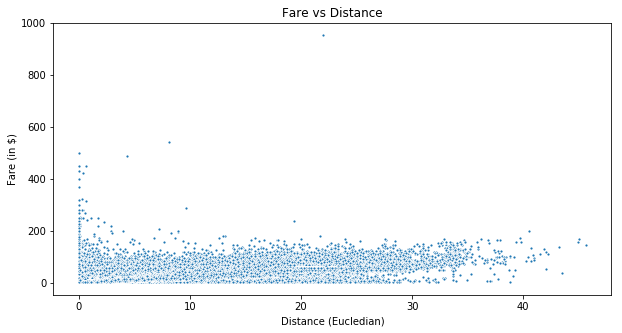

In [45]:
plt.figure(1)
fig, ax = plt.subplots(figsize=(10, 5))
fvd_scatter_plot = sns.scatterplot(train_df.h_dist, train_df.fare_amount, marker='.', ax=ax)
plt.title("Fare vs Distance")
plt.xlabel("Distance (Eucledian)")
plt.ylabel("Fare (in $)")

plt.savefig('fvd_scatter_plot.png')

From the above plot we can see(ignoring the outliers) a general trend where the fare rises linearly as a function of distance travelled, which was expected from our correlation calcualations.


So our next step in the process would be to eliminate the outliers. 
    1. As per Wikipedia: The base fare for yellow taxis is $2.50, so the fare_amount being less than that does not makes sense.
    2. I'm also removing all distance values that are ~0 miles. 0 miles would only mean that, the trip was cancelled or ended abruptly by the rider. This is a special case scenario and I think will be problematic for the remaining calculations, like the taxi fare per mile, in the data.

In [33]:
drop_indexes = train_df[(train_df.fare_amount < 2.5) | (train_df.h_dist == 0)].index
print("Length of rows dropped: {}".format(len(drop_indexes)))
train_df.drop(drop_indexes, inplace=True)

Length of rows dropped: 100867


Text(0.5,1,'Value Distribution of Fare Amount and Distance (Normalized)')

<Figure size 432x288 with 0 Axes>

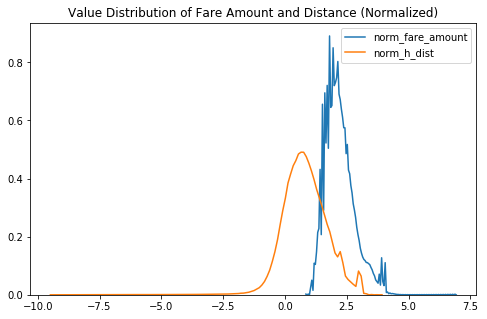

In [47]:
import math as m
train_df['norm_fare_amount'] = train_df.fare_amount.apply(m.log)
train_df['norm_h_dist'] = train_df.h_dist.apply(m.log)

plt.figure(1)
fig, ax = plt.subplots(figsize=(8, 5))
nfa = sns.kdeplot(train_df.norm_fare_amount, ax=ax)
nhd = sns.kdeplot(train_df.norm_h_dist, ax=ax)

plt.title("Value Distribution of Fare Amount and Distance (Normalized)")

Since there is no linear correlation between time of day and fare or distance, there would be no point plotting a scatter plot between the variables. 
Although, an interesting thing to note would be how dense the data is at different times. I can get an idea of this metric using a classic violin plot.

<Figure size 432x288 with 0 Axes>

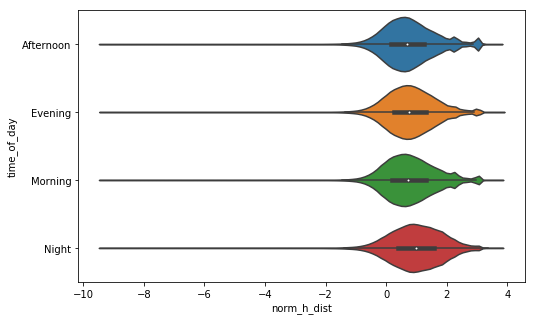

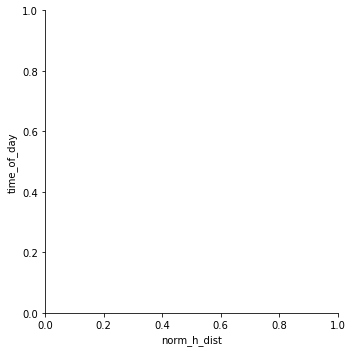

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.catplot(x='norm_h_dist', y='time_of_day', data=train_df, kind='violin', ax=ax)

<Figure size 432x288 with 0 Axes>

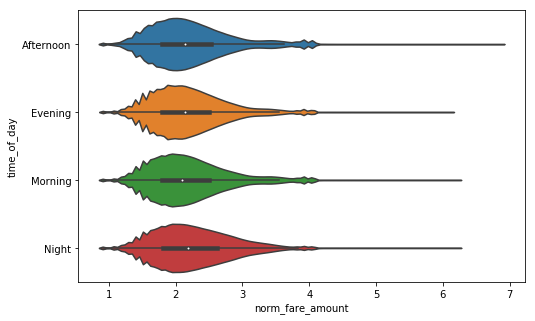

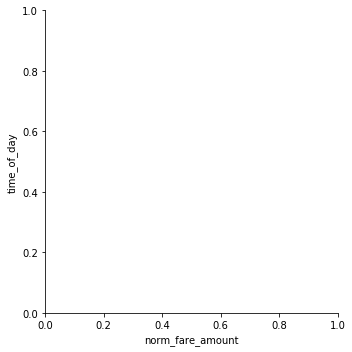

In [49]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.catplot(x='norm_fare_amount', y='time_of_day', data=train_df, kind='violin', ax=ax)

#### Q4. Create an exciting plot of your own using the dataset that you think reveals something very interesting.   Explain what it is, and anything else you learned. (15 pt)
#### Q5. Generate additional features like those from (2) from the given data set. What additional features can you create? (10 pt)

__Ideas:__
* Taxi rate: fare/mile
* demand, avg distance travelled, avg taxi fare amount per hour, day, date, month, year

In [50]:
train_df['t_rate'] = train_df['fare_amount']/train_df['h_dist']

In [51]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'].apply(lambda x: x.split()[0]))

In [52]:
train_df['month'] = train_df.pickup_datetime.apply(lambda x: x.month)
train_df['year'] = train_df.pickup_datetime.apply(lambda x: x.year)
train_df['date'] = train_df.pickup_datetime.apply(lambda x: x.day)

In [53]:
train_df['day'] = train_df.pickup_datetime.apply(lambda x: x.day_name()).astype('category')

In [54]:
display(train_df.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,pickup_hour,time_of_day,norm_fare_amount,norm_h_dist,t_rate,month,year,date,day
key,,,,,,,,,,,,,,,,,
2009-06-15 17:26:21.0000001,4.500,2009-06-15,-73.844,40.721,-73.842,40.712,1,1.031,17,Evening,1.504,0.030,4.366,6,2009,15,Monday
2010-01-05 16:52:16.0000002,16.900,2010-01-05,-74.016,40.711,-73.979,40.782,1,8.450,16,Afternoon,2.827,2.134,2.000,1,2010,5,Tuesday
2011-08-18 00:35:00.00000049,5.700,2011-08-18,-73.983,40.761,-73.991,40.751,2,1.390,0,Night,1.740,0.329,4.102,8,2011,18,Thursday
2012-04-21 04:30:42.0000001,7.700,2012-04-21,-73.987,40.733,-73.992,40.758,1,2.799,4,Night,2.041,1.029,2.751,4,2012,21,Saturday
2010-03-09 07:51:00.000000135,5.300,2010-03-09,-73.968,40.768,-73.957,40.784,1,1.999,7,Morning,1.668,0.693,2.651,3,2010,9,Tuesday


In [55]:
hour_demand = train_df.pickup_hour.value_counts()
daily_demand = train_df.date.value_counts()
monthly_demand = train_df.month.value_counts()
yearly_demand = train_df.year.value_counts()
demand_by_day = train_df.day.value_counts()

Let's plot the demand against each variable to see if we can pickup any patterns. The demand here just refers to the total number of records corresponding to the variable which would just mean that many taxis were hired during the period.

##### Plots to see the demand accross various factors

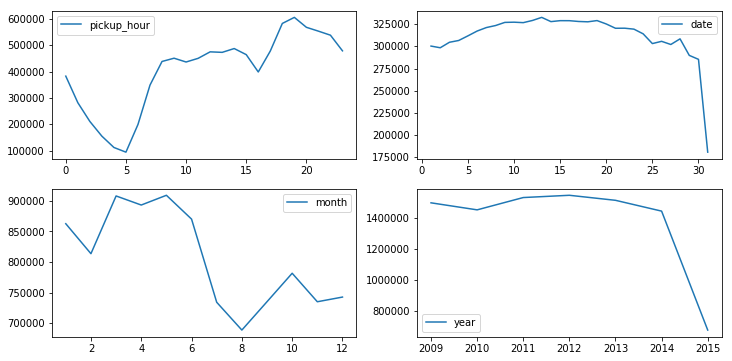

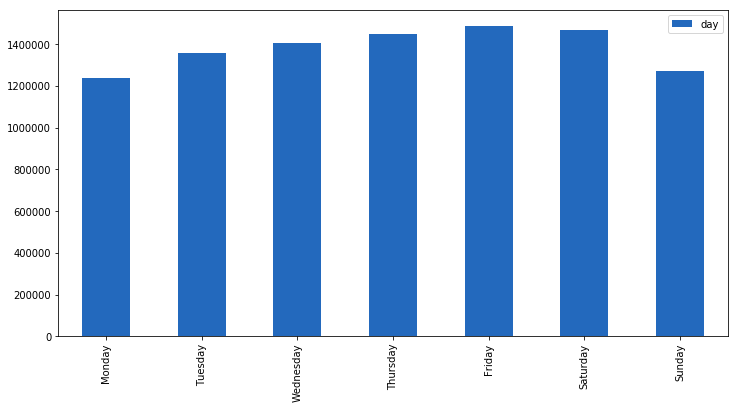

In [56]:
plt.figure(1)
hour_demand.sort_index(ascending=True).plot(kind='line', legend=True, ax=plt.subplot(221), figsize=(12,6))
daily_demand.sort_index(ascending=True).plot(kind='line', legend=True, ax=plt.subplot(222))
monthly_demand.sort_index(ascending=True).plot(kind='line', legend=True, ax=plt.subplot(223))
yearly_demand.sort_index(ascending=True).plot(kind='line', legend=True, ax=plt.subplot(224))

plt.figure(2)
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
demand_by_day.loc[week].plot(kind='bar', legend=True, figsize=(12,6), colormap="vlag")

#### Plotting the relationship of mean fare amount across various factors

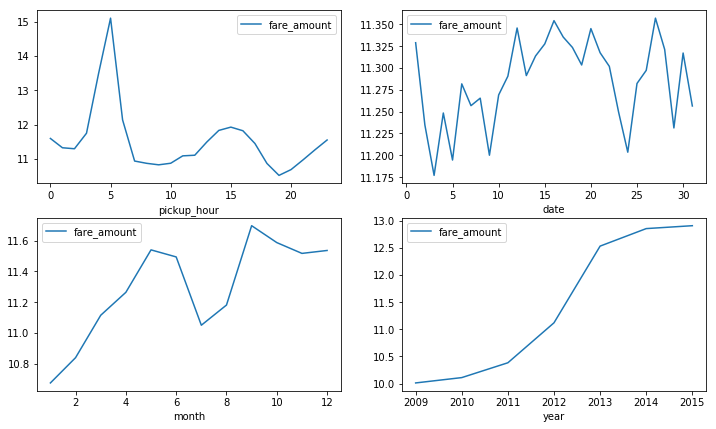

<Figure size 432x288 with 0 Axes>

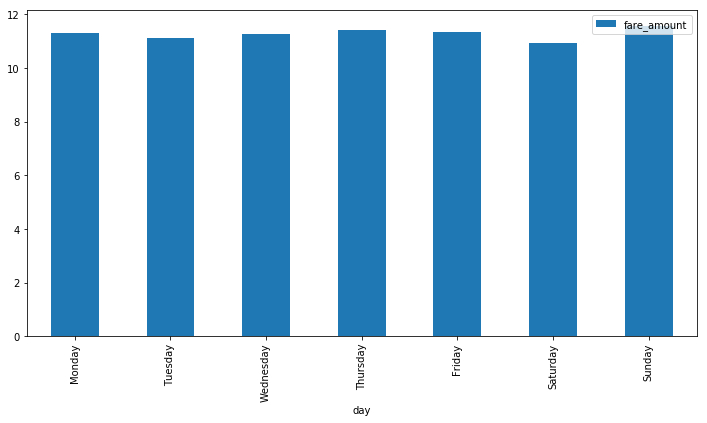

In [57]:
plt.figure(1)
train_df[['pickup_hour', 'fare_amount']].groupby('pickup_hour').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(221), figsize=(12,7))
train_df[['date', 'fare_amount']].groupby('date').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(222))
train_df[['month', 'fare_amount']].groupby('month').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(223))
train_df[['year', 'fare_amount']].groupby('year').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(224))

plt.figure(2)
train_df[['day', 'fare_amount']].groupby('day').mean().loc[week].plot(kind='bar', legend=True, figsize=(12,6))


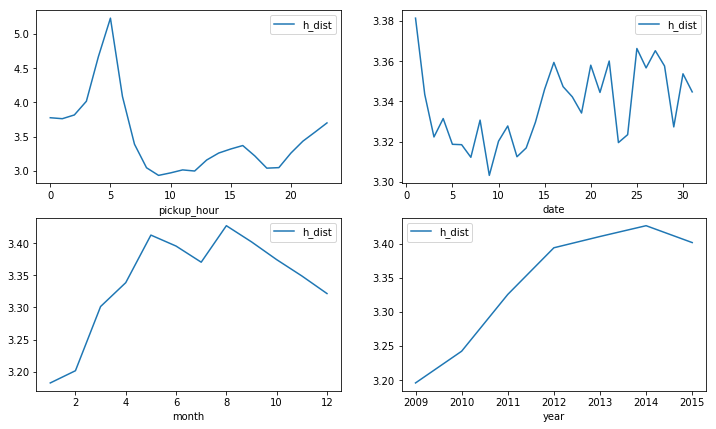

<Figure size 432x288 with 0 Axes>

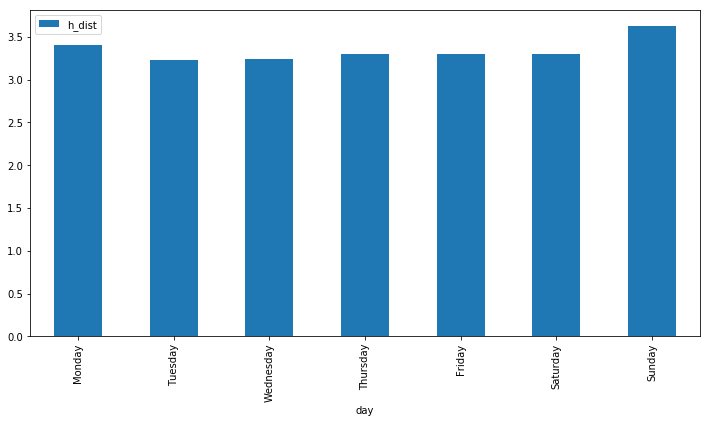

In [58]:
plt.figure(1)
train_df[['pickup_hour', 'h_dist']].groupby('pickup_hour').mean().sort_index().plot(kind='line', legend=True, figsize=(12, 7), ax=plt.subplot(221))
train_df[['date', 'h_dist']].groupby('date').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(222))
train_df[['month', 'h_dist']].groupby('month').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(223))
train_df[['year', 'h_dist']].groupby('year').mean().sort_index().plot(kind='line', legend=True, ax=plt.subplot(224))

plt.figure(2)
train_df[['day', 'h_dist']].groupby('day').mean().loc[week].plot(kind='bar', legend=True, figsize=(12, 6))


Another thing to consider is that rides from or to the JFK airport have a fixed fare ~$45 as per the nyc.gov website. My current data employs no strategy to use that to it's advantage. I'll split out the two rides based on airport coordinates and see if I can actually see a difference in the fare distribution of the rides.

In [59]:
jfk = {
    'min_long':-73.835,
    'min_lat':40.619,
    'max_long':-73.748, 
    'max_lat':40.665
}

def check_longitude(long):
    return long.between(jfk['min_long'], jfk['max_long'], inclusive=True)
    
def check_latitude(lat):
    return lat.between(jfk['min_lat'], jfk['max_lat'], inclusive=True)

def is_jfk(df):
    return (check_longitude(df['pickup_longitude']) & check_latitude(df['pickup_latitude'])) | (check_longitude(df.dropoff_longitude) & check_latitude(df.dropoff_latitude))

airport_rides = train_df[is_jfk(train_df)]

In [60]:
non_airport_rides = train_df.drop(airport_rides.index)

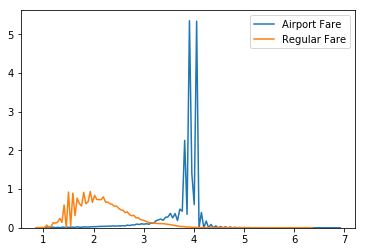

In [61]:
sns.kdeplot(airport_rides.norm_fare_amount, label='Airport Fare')
sns.kdeplot(non_airport_rides.norm_fare_amount, label='Regular Fare')

There is clearly a difference between the two types of rides and how the fares are calculated. I feel it would be worthwhile to consider these two as seperate rides for our prediction calculations. We can do that by intorducing a new feature "airport_ride".

In [62]:
train_df['airport_ride'] = 0 # False but using numerical value to facilitate regression
train_df.at[is_jfk(train_df), 'airport_ride'] = 1
train_df[train_df.airport_ride == 1].count()

fare_amount          208787
pickup_datetime      208787
pickup_longitude     208787
pickup_latitude      208787
dropoff_longitude    208787
dropoff_latitude     208787
passenger_count      208787
h_dist               208787
pickup_hour          208787
time_of_day          208787
norm_fare_amount     208787
norm_h_dist          208787
t_rate               208787
month                208787
year                 208787
date                 208787
day                  208787
airport_ride         208787
dtype: int64

There's a high correlatin between the flag and, fare_amount and h_dist which is good sign. We can use this as a parameter for our prediction.

In [63]:
train_df.corr()['fare_amount']

fare_amount          1.000
pickup_longitude     0.432
pickup_latitude     -0.220
dropoff_longitude    0.309
dropoff_latitude    -0.186
passenger_count      0.016
h_dist               0.878
pickup_hour         -0.017
norm_fare_amount     0.905
norm_h_dist          0.645
t_rate               0.082
month                0.025
year                 0.119
date                 0.002
airport_ride         0.545
Name: fare_amount, dtype: float64

The fare rate for each ride we calculated earler also has a lot of discrepencies. This originally could have been because of the fixed rate that was charged for every ride from/to JFK. Let's look at the distribution after we remove those fields.

In [64]:
train_df[train_df.airport_ride == 0].t_rate.describe(percentiles=np.linspace(0,1,101))


count   9466179.000
mean         57.426
std        3633.955
min           0.077
0%            0.077
1%            1.850
2%            1.998
3%            2.093
4%            2.167
5%            2.230
6%            2.287
7.0%          2.339
8%            2.387
9%            2.432
10%           2.475
11%           2.517
12%           2.556
13%           2.594
14.0%         2.632
15%           2.669
16%           2.705
17%           2.741
18%           2.776
19%           2.811
20%           2.846
21%           2.880
22%           2.914
23%           2.948
24%           2.981
25%           3.014
            ...    
72%           4.887
73%           4.950
74%           5.017
75%           5.086
76%           5.158
77%           5.234
78%           5.313
79%           5.397
80%           5.485
81%           5.578
82%           5.678
83%           5.784
84%           5.898
85%           6.021
86%           6.154
87%           6.301
88%           6.462
89%           6.642
90%           6.846


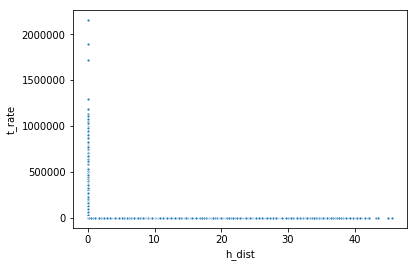

In [65]:
sns.scatterplot(train_df.h_dist, train_df.t_rate, marker='.')

The rate seems to be too high for a very small distance. This does not make sense since the rate should be somewhat contant. Let's explore these values futher.

In [66]:
outlier_rates = train_df[(train_df.t_rate < 1.8) | (train_df.t_rate > 23)]

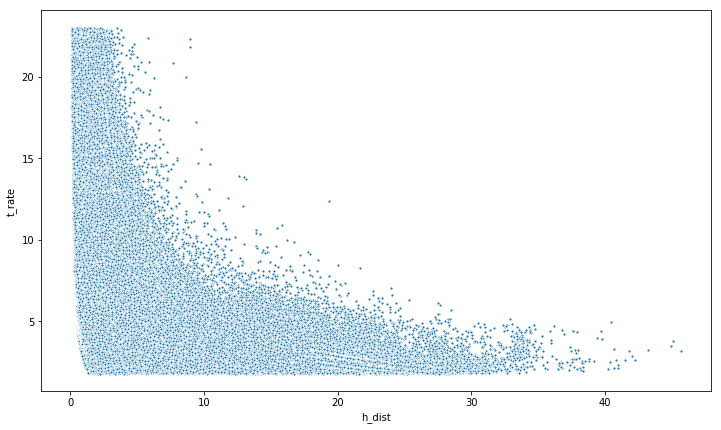

In [67]:
outlier_rates.count()
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(train_df.drop(outlier_rates.index).h_dist, train_df.drop(outlier_rates.index).t_rate, marker='.', ax=ax)

In [68]:
train_df.drop(outlier_rates.index, inplace=True)

In [69]:
train_df.corr()['fare_amount']

fare_amount          1.000
pickup_longitude     0.453
pickup_latitude     -0.226
dropoff_longitude    0.320
dropoff_latitude    -0.197
passenger_count      0.018
h_dist               0.922
pickup_hour         -0.016
norm_fare_amount     0.910
norm_h_dist          0.787
t_rate              -0.226
month                0.026
year                 0.125
date                 0.002
airport_ride         0.566
Name: fare_amount, dtype: float64

Let's see if we're expecting any imporovement in the fare_amount predictions with this changes

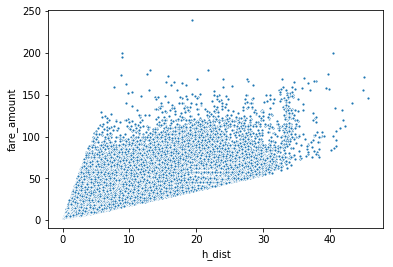

In [70]:
sns.scatterplot(train_df.h_dist, train_df.fare_amount, marker='.')

#### Q6. Set up a simple linear regression model to predict taxi fare. Use your generated features from the previous task if applicable. How well/badly does it work? What are the coefficients for your features? Which variable(s) are the most important one? (12 pt)

In [71]:
# Splitting the data into training and testing sets
import sklearn.model_selection as skl
X_train, X_test, y_train, y_test = skl.train_test_split(train_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']], train_df['fare_amount'], test_size=0.2, shuffle=True)


__Baseline Model__

In [83]:
avg_fare = train_df.fare_amount.mean()
# baseline_model would be predicting when we don't use any sort of predicting model
# to get the fare_amount but just return the avg value.
y_base = [avg_fare]

__Test Model 1__

In [85]:
from sklearn import linear_model as LM
from sklearn import ensemble as EN
from sklearn import svm

In [86]:
coef = LM.LinearRegression()
coef.fit(X_train, y_train)
y_pred = coef.predict(X_test)

In [87]:
coef.coef_

array([  2.43160971,  -3.23468961,   0.07080263,   0.5054074 ,
        16.77599911,  -6.3382601 ,   3.78954327, -12.94111277])

In [88]:
from sklearn.metrics import mean_squared_error as mse, r2_score, explained_variance_score as evs

In [89]:
mse(y_test, y_pred), r2_score(y_test, y_pred), evs(y_test, y_pred)

(11.452740469468633, 0.8653128339852482, 0.8653128442224836)

In [90]:
# Comparing with baseline model
y_pred_base = y_base * len(y_test)
mse(y_test, y_pred_base), r2_score(y_test, y_pred_base), evs(y_test, y_pred_base)

(85.03216053472235, -2.2096418250683314e-08, 2.220446049250313e-16)

In [ ]:
external_seasons = pd.read_csv('../dataset/')

In [127]:
X_train, X_test, y_train, y_test = skl.train_test_split(train_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']][:5000000], train_df['fare_amount'][:5000000], test_size=0.25, shuffle=True)

In [128]:
gbr = EN.GradientBoostingRegressor()

In [130]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [131]:
y_pred = gbr.predict(X_test)

In [132]:
mse(y_test, y_pred), r2_score(y_test, y_pred), evs(y_test, y_pred)

(7.835325030352737, 0.9078465734507791, 0.907847502008505)

In [97]:
X_train, X_test, y_train, y_test = skl.train_test_split(train_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']][:3000000], train_df['fare_amount'][:3000000], test_size=0.25, shuffle=True)

In [98]:
rfr = EN.RandomForestRegressor(n_estimators=15, max_depth=25)

In [99]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [100]:
y_pred  = rfr.predict(X_test)

In [101]:
mse(y_pred, y_test), r2_score(y_test, y_pred), evs(y_test, y_pred), rfr.score(X_test, y_test)

(6.640701975629394, 0.9222186391961817, 0.9222370260131155, 0.9222186391961819)

In [102]:
br = LM.BayesianRidge()
X_train, X_test, y_train, y_test = skl.train_test_split(train_df[['h_dist', 'airport_ride', 'month', 'year']], train_df['fare_amount'], test_size=0.2, shuffle=True)

In [104]:
br.fit(X_train, y_train)
y_pred = br.predict(X_test)
mse(y_test, y_pred), r2_score(y_test, y_pred), evs(y_test, y_pred)

(11.841172501451922, 0.8607372181667412, 0.8607372771419852)

Since we have a base model that's performing better than random guessing, now let's prepare the test.csv to use this

## Let's begin predicting the fare amount on test data...

In [105]:
test_df = pd.read_csv('../dataset/test.csv')
test_df.set_index('key', inplace=True, drop=True)
test_df['h_dist'] = test_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(lambda x: haversine(*x), axis=1)
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist
count,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671,3.435
std,0.043,0.034,0.039,0.035,1.279,3.972
min,-74.252,40.573,-74.263,40.569,1.000,0.000
25%,-73.993,40.736,-73.991,40.735,1.000,1.298
50%,-73.982,40.753,-73.980,40.754,1.000,2.217
75%,-73.968,40.767,-73.964,40.769,2.000,4.045
max,-72.987,41.710,-72.991,41.697,6.000,99.996


In [106]:
test_df['airport_ride'] = 0
test_df.at[is_jfk(test_df), 'airport_ride'] = 1

In [107]:
test_df['month'] = pd.to_datetime(test_df.pickup_datetime).apply(lambda x: x.month)
test_df['year'] = pd.to_datetime(test_df.pickup_datetime).apply(lambda x: x.year)
test_df['pickup_hour'] = pd.to_datetime(test_df.pickup_datetime).apply(lambda x: x.hour)

In [108]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,airport_ride,month,year,pickup_hour
key,,,,,,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973,40.764,-73.981,40.744,1,2.323,0,1,2015,13
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.987,40.719,-73.999,40.739,1,2.425,0,1,2015,13
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.983,40.751,-73.980,40.746,1,0.619,0,10,2011,11
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981,40.768,-73.990,40.752,1,1.961,0,12,2012,21
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966,40.790,-73.989,40.744,1,5.387,0,12,2012,21


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,h_dist,airport_ride,month,year,pickup_hour
key,,,,,,,,,,,
2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968,40.797,-73.956,40.780,6,2.125,0,5,2015,12
2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.946,40.804,-73.960,40.776,6,3.271,0,1,2015,17
2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.992,40.727,-73.790,40.647,6,19.184,1,4,2015,20
2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.986,40.735,-73.939,40.802,6,8.343,0,1,2015,1
2015-01-18 14:06:23.0000006,2015-01-18 14:06:23 UTC,-73.988,40.754,-74.000,40.759,6,1.181,0,1,2015,14


Since this is no longer testing the model using train_test_split, let's use the whole dataset to train our Linear Regression classifier

In [109]:
lin_reg_model1 = LM.LinearRegression()

In [110]:
lin_reg_model1.fit(train_df[['h_dist', 'airport_ride', 'month', 'year']], train_df['fare_amount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [111]:
fare_amount = lin_reg_model1.predict(test_df[['h_dist', 'airport_ride', 'month', 'year']])

In [112]:
fare_amount

array([10.07375328, 10.32405644,  4.50999513, ..., 50.15173163,
       24.83359984,  7.27283609])

In [113]:
pd.DataFrame(fare_amount, index=test_df.index, columns=['fare_amount']).to_csv('../dataset/sample_submission.csv', mode='w')

In [114]:
len(fare_amount)

9914

In [121]:
def get_submission_file(fare_amount):
    pd.DataFrame(fare_amount, index=test_df.index, columns=['fare_amount']).to_csv('../dataset/sample_submission.csv', mode='w')

In [122]:
br = LM.BayesianRidge()

In [123]:
br.fit(train_df[['h_dist', 'airport_ride', 'month', 'year']], train_df['fare_amount'])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [124]:
fare_amount = br.predict(test_df[['h_dist', 'airport_ride', 'month', 'year']])

In [125]:
get_submission_file(fare_amount)

__Adding longitudes/latitudes to the feature list__ 

In [137]:
fare_amount = gbr.predict(test_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']])

In [138]:
get_submission_file(fare_amount)

In [133]:
fare_amount = rfr.predict(test_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']])

In [134]:
get_submission_file(fare_amount)

__Increasing the number of datapoints in training to 3M__
_not a significant enough change in the local mean squared error but still wanna try out the sample submission file_

In [ ]:
fare_amount = rfr.predict(test_df[['h_dist', 'airport_ride', 'month', 'year', 'pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']])

In [136]:
get_submission_file(fare_amount)